# ChainerでVAEを書いてみる
* 以下のページを参考に
  * https://github.com/RyotaKatoh/chainer-Variational-AutoEncoder
* VAEについては以下を参照した
  * http://papers.nips.cc/paper/5352-semi-supervised-learning-with-deep-generative-models.pdf
  * http://deeplearning.jp/wp-content/uploads/2014/04/dl_hacks2015-04-21-iwasawa1.pdf


In [1]:
%matplotlib inline
import sys, os
import numpy as np
import pandas as pd

import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

import six

import matplotlib.pyplot as plt

In [2]:
# chainer exampleに付属のdata.pyをimportする. mnistのダウンロードのため
import data

## GPU設定

In [3]:
gpu_flag = -1
if gpu_flag >= 0:
    cuda.check_cuda_available()
xp = cuda.cupy if gpu_flag >= 0 else np

## MNISTデータのダウンロードといくつかプロットして確認

In [4]:
mnist = data.load_mnist_data()
# 70,000の手書き数字データ

In [5]:
# 手書き数字データを描画する関数
def draw_digit(data):
    size = 28
    plt.figure(figsize=(2, 2))

    X, Y = np.meshgrid(range(size),range(size))
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(X, Y, Z)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

    plt.show()

# 複数の画像配列になっているdata列を描画する
def draw_digit2(data):
    size = 28
    n = data.shape[0]
    plt.figure(figsize=(n, 2))
    cnt = 1
    for idx in np.arange(n):
        plt.subplot(1, n, cnt)
        X, Y = np.meshgrid(range(size),range(size))
        Z = data[idx].reshape(size,size)   # convert from vector to 28x28 matrix
        Z = Z[::-1,:]             # flip vertical
        plt.xlim(0,27)
        plt.ylim(0,27)
        plt.pcolor(X, Y, Z)
        plt.gray()
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()

# いくつかプロット
def draw_digit_multi(data, n=10):
    # サンプラー
    indexes = np.random.permutation( len(data) )[:n]
    # 
    size = 28
    plt.figure(figsize=(15, 2))
    # plot
    cnt = 1
    for idx in indexes:
        plt.subplot(1, n, cnt)
        X, Y = np.meshgrid(range(size),range(size))
        Z = data[idx].reshape(size,size)   # convert from vector to 28x28 matrix
        Z = Z[::-1,:]
        plt.xlim(0, size-1)
        plt.ylim(0, size-1)
        plt.pcolor(X, Y, Z)
        plt.gray()
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()
    return indexes

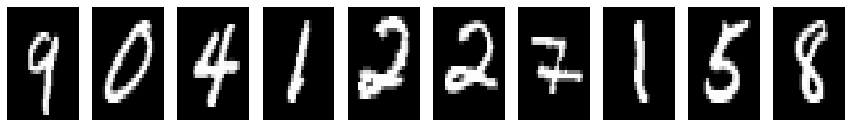

labels : 
[9 0 4 1 2 2 7 1 5 8]


In [6]:
idxs = draw_digit_multi(mnist['data'])
print "labels : "
print mnist['target'][idxs]

## パラメータの設定

In [7]:
batchsize = 100 # ミニバッチのサイズ
n_epoch = 5     # epoch数
n_latent = 100   # 潜在変数の次元(DCGANで言うところのプライヤーベクトルの次元)

# Optimizer
al = 0.001
b1 = 0.9
b2 = 0.999

## データの前処理
* [0,1]の範囲に正規化
* float32, int32に変換

In [8]:
# 正規化
mnist['data'] = mnist['data'].astype(np.float32)
mnist['data'] /= 255
mnist['target'] = mnist['target'].astype(np.int32)
# 訓練データとテストデータに分割
N = 60000
x_train, x_test = np.split(mnist['data'],   [N])
y_train, y_test = np.split(mnist['target'], [N])
N_test = y_test.size

## モデルの定義
* 公式exampleではnet.pyとして別ファイルになっている

In [9]:
# 変分誤差を計算するためにKLダイバージェンスの関数をimportしておく
from chainer.functions.loss.vae import gaussian_kl_divergence

In [10]:
class VAE(chainer.Chain):
    """Variational AutoEncoder"""
    def __init__(self, n_in, n_latent, n_h):
        super(VAE, self).__init__(
            ## ネットワーク構造の定義
            # encoder
            le1=L.Linear(n_in, n_h),
            le2_mu=L.Linear(n_h, n_latent),
            le2_ln_var=L.Linear(n_h, n_latent),
            # decoder
            ld1=L.Linear(n_latent, n_h),
            ld2=L.Linear(n_h, n_in),
        )

    def __call__(self, x, sigmoid=True):
        """AutoEncoder"""
        # 下記、encodeとdecodeの中身をこの中に書いても良いがencodeとｄｅｃｏｄｅは他でも使うので再利用性を高めるために
        return self.decode(self.encode(x)[0], sigmoid)
    
    def encode(self, x):
        # 推論モデル, 中間表現のベクトルqを学習
        h1 = F.tanh(self.le1(x))
        mu = self.le2_mu(h1)
        ln_var = self.le2_ln_var(h1)  # log(sigma**2)
        return mu, ln_var

    def decode(self, z, sigmoid=True):
        # 中間表現ベクトルqを入力として(z), 画像を生成
        h1 = F.tanh(self.ld1(z))
        h2 = self.ld2(h1)
        if sigmoid:
            return F.sigmoid(h2)
        else:
            return h2

    def get_loss_func(self, C=1.0, k=1, train=True):
        """Get loss function of VAE.
        The loss value is equal to ELBO (Evidence Lower Bound)
        multiplied by -1.
        Args:
            C (int): Usually this is 1.0. Can be changed to control the
                second term of ELBO bound, which works as regularization.
            k (int): Number of Monte Carlo samples used in encoded vector.
            train (bool): If true loss_function is used for training.
        """
        def lf(x):
            mu, ln_var = self.encode(x)
            batchsize = len(mu.data)
            # reconstruction loss
            rec_loss = 0
            for l in six.moves.range(k):
                z = F.gaussian(mu, ln_var)
                rec_loss += F.bernoulli_nll(x, self.decode(z, sigmoid=False)) / (k * batchsize)
            self.rec_loss = rec_loss
            self.loss = self.rec_loss + C * gaussian_kl_divergence(mu, ln_var) / batchsize
            return self.loss
        return lf

## VAEモデルとOptimizerを設定して学習の準備をする

In [11]:
# モデルの設定
model = VAE(784, n_latent, 500) # VAE(n_in, n_latent, n_h)  input=28*28=784
if gpu_flag >= 0:
    cuda.get_device(gpu_flag).use()
    model.to_gpu()
xp = np if gpu_flag < 0 else cuda.cupy

In [12]:
# Optimizerを定義する
optimizer = optimizers.Adam(alpha=al, beta1=b1, beta2=b2)
optimizer.setup(model)

## 学習の実施

In [13]:
for epoch in six.moves.range(1, n_epoch + 1):
    print('epoch', epoch)
    
    # training
    ## 訓練データのsampler
    perm = np.random.permutation(N)
    ## lossのbuffer
    sum_loss = 0       # total loss
    sum_rec_loss = 0   # reconstruction loss
    ## バッチ学習
    for i in six.moves.range(0, N, batchsize):
        x = chainer.Variable(xp.asarray(x_train[perm[i:i + batchsize]])) # バッチ分のデータの抽出
        
        ## Optimize
        # optimizerのupdateメソッドにloss関数とデータを与える　こうすると中でいろいろやってくれる
        #optimizer.update(model.get_loss_func(), x)
        # 勾配を明示的に計算する場合
        model.zerograds()
        loss = model.get_loss_func()(x)
        loss.backward()
        optimizer.update()
        
        # chainer.computational_graphは1.7からの実装

        sum_loss += float(model.loss.data) * len(x.data)
        sum_rec_loss += float(model.rec_loss.data) * len(x.data)

    print('train mean loss={}, mean reconstruction loss={}'.format(sum_loss / N, sum_rec_loss / N))

('epoch', 1)
train mean loss=165.724434484, mean reconstruction loss=136.723977305
train loss2 = 165.724434484
('epoch', 2)
train mean loss=132.764290924, mean reconstruction loss=99.8397902425
train loss2 = 132.764290924
('epoch', 3)
train mean loss=123.105392443, mean reconstruction loss=91.362994194
train loss2 = 123.105392443
('epoch', 4)
train mean loss=118.972344653, mean reconstruction loss=87.9765623983
train loss2 = 118.972344653
('epoch', 5)
train mean loss=116.227115555, mean reconstruction loss=85.9917687098
train loss2 = 116.227115555


### 結果の確認

training image


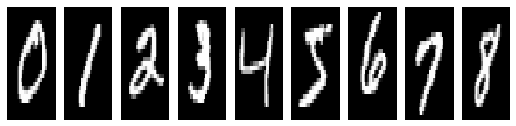

reconstruction image


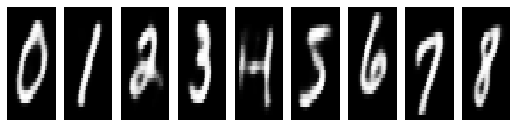

In [14]:
train_ind = [1, 3, 5, 10, 2, 0, 13, 15, 17]
x = chainer.Variable(xp.asarray(x_train[train_ind]), volatile='on')
x1 = model(x)

print "training image"
draw_digit2(x_train[train_ind])

print "reconstruction image"
#draw_digit2(x1.data.get())
draw_digit2(x1.data)

decode image from random vector


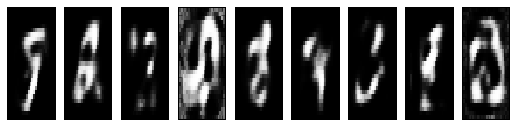

In [15]:
# draw images from randomly sampled z
z = chainer.Variable(xp.random.normal(0, 1, (9, n_latent)).astype(np.float32))
x = model.decode(z)

print "decode image from random vector"
#draw_digit2(x.data.get())
draw_digit2(x.data)